In [1]:
cd ../analysis/

/home/jlee782/hcomp_paper_seg/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from withClustAnalysis import *
from hcomp_paper_viz import *

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# Run once
#from qualityBaseline import compute_self_BBvals
# print "generate baseline comparisons"
# compute_self_BBvals(compute_metrics=['simple','area']) #run once
# retreival_df = compute_best_average_heuristics_workers_baselines(rerun_existing=True) #run once

generate baseline comparisons


/home/jlee782/.local/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


# Retreival based heuristic models

-  if we only pick from the best cluster, if no clustering done then retain the same worker performance as before

In [107]:
from baseline import compute_worker_qualities_against_real_performance

In [108]:
obj_clusters = clusters()

In [109]:
clust_df = pd.read_csv("spectral_clustering_all_hard_obj.csv")
noClust_obj =[obj for obj in object_lst if obj not in clust_df.objid.unique() ]
clustObj = clust_df.objid.unique()

In [110]:
retreival_df= pd.read_csv("pixel_em/individual_worker_performance.csv")
retreival_df["sample_num"]=retreival_df.apply(lambda x:int(x["sample"].split("rand")[-1]),axis=1)
no_cluster_retreival_df = retreival_df[retreival_df["clust"]==-1]
cluster_retreival_df = retreival_df[((retreival_df["clust"]!=-1) & (retreival_df["objid"].isin(clustObj)))|((retreival_df["clust"]==-1) & (~retreival_df["objid"].isin(clustObj)))]

In [111]:
#BAD!
# best_clust_df = compute_best_worker_picking()
# cluster_retreival_df=filter_best_clust(retreival_df,best_clust_df)

In [112]:
def best_cluster(x):
    try:
        return obj_clusters[x["sample"]][str(x["objid"])]
    except(KeyError): #non clustered cases
        return -1

retreival_df["best_clust"]=retreival_df.apply(lambda x: best_cluster(x),axis=1)
cluster_retreival_df = retreival_df[retreival_df["best_clust"]==retreival_df["clust"]]
assert len(cluster_retreival_df.groupby(["sample","objid"]).count())==46*31

In [124]:
retreivalAlgoMap={
    'NumPt':'orange',
    'AreaRatio':'green',
    'AvrgWorker':'blue',
    'BestWorker':'red'
}

For vision, we scan a variety of inclusion thresholds as well as different levels of segmentation granularities. For each object, we pick parameter that yields the best performing Jaccard.

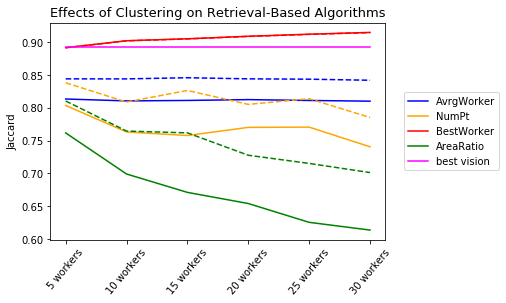

In [193]:
vision = pd.read_csv("pixel_em/vision_only_performance.csv")

NworkerPerformance = no_cluster_retreival_df.groupby("num_workers").mean()
for algo in retreivalAlgoMap.keys():
    algoJ = "J [{}]".format(algo)
    plt.plot(np.array(NworkerPerformance[algoJ]),label=algo,color=retreivalAlgoMap[algo])

NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
for algo in  retreivalAlgoMap.keys():
    algoJ = "J [{}]".format(algo)
    plt.plot(np.array(NworkerPerformance[algoJ]),linestyle='--',color=retreivalAlgoMap[algo])

max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
y = np.ones_like(np.array(NworkerPerformance[algoJ]))
plt.plot(y*max_vision_k_thresh,label="best vision",color="magenta")
lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
#plt.legend(loc="lower left",fontsize=8)    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Effects of Clustering on Retrieval-Based Algorithms",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.savefig("ClusteringEffectOnRetreival.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [127]:
from tabulate import tabulate

In [128]:
megadfd =[]
for algo in algoMap.keys():
    keys = ['P [{}]'.format(algo), u'R [{}]'.format(algo), 'J [{}]'.format(algo), u'FPR% [{}]'.format(algo),'FNR% [{}]'.format(algo)]
    performance = list(cluster_retreival_df.mean()[keys])
    lst = [algo]
    lst.extend(performance)
    megadfd.append(lst)

In [129]:
megadf = pd.DataFrame(megadfd, columns=["algo","P","R","J","FPR%","FNR%"])

In [130]:
print tabulate(megadf,showindex=False,headers=megadf.columns,tablefmt="latex",floatfmt=".2f")

\begin{tabular}{lrrrrr}
\hline
 algo       &    P &    R &    J &   FPR\% &   FNR\% \\
\hline
 AvrgWorker & 0.91 & 0.92 & 0.84 &   7.94 &   0.52 \\
 NumPt      & 0.87 & 0.92 & 0.82 &   7.86 &   1.10 \\
 BestWorker & 0.95 & 0.95 & 0.90 &   5.23 &   0.17 \\
 AreaRatio  & 0.79 & 0.94 & 0.77 &   5.51 &   2.06 \\
\hline
\end{tabular}


- add MV in this plot 
- leave out clustering for this 

# Big Table of all algo x results 

# Comparing MV with EM ; clust v.s. no clust

In [99]:
from analyze_prjs import clust_vs_noclust

In [100]:
algoMap = {
    'GTLSA':'orange',
    "basic":'green',
    "GT":'blue',
    "isoGT":'red',
    "isoGTLSA": 'cyan',
    "isobasic": 'magenta',
    "MV":"black"
}

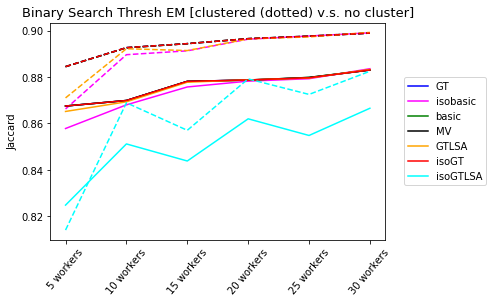

In [101]:
for algo in algoMap.keys():
    # we only ran on the best clusters, so the results should only be on the best clusters if not -1
    x,algo_noclust,algo_clust=clust_vs_noclust(algo,filtered=False)
    plt.plot(algo_noclust,label=algo,color = algoMap[algo])
    plt.plot(algo_clust,linestyle="--",color = algoMap[algo])
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Binary Search Thresh EM [clustered (dotted) v.s. no cluster]",fontsize=13)

basic, isoGT and GT are all very close to MV

In [26]:
def avrg_percent_change(clust,noClust):
    return "{:.3f}%".format(np.mean((np.array(clust)-np.array(noClust))/np.array(noClust))*100)

__Comparing cluster v.s. no cluster__

In [27]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change due to clustering for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    print "{} :{}".format("MV",avrg_percent_change(MV_clust,MV_noclust))
    for algo in algoMap.keys():
        x,algo_noclust,algo_clust=clust_vs_noclust(algo,metric=metric,filtered=False)
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,algo_noclust))

------------
percent change due to clustering for metric: precision
MV :0.369%
GT :0.372%
isobasic :0.344%
basic :0.375%
MV :0.369%
GTLSA :0.202%
isoGT :0.372%
isoGTLSA :-0.329%
------------
percent change due to clustering for metric: recall
MV :1.672%
GT :1.674%
isobasic :1.701%
basic :1.672%
MV :1.672%
GTLSA :1.415%
isoGT :1.674%
isoGTLSA :1.762%
------------
percent change due to clustering for metric: jaccard
MV :2.047%
GT :2.050%
isobasic :1.860%
basic :2.050%
MV :2.047%
GTLSA :1.784%
isoGT :2.050%
isoGTLSA :1.377%
------------
percent change due to clustering for metric: FNR%
MV :-21.145%
GT :-21.164%
isobasic :-21.343%
basic :-21.149%
MV :-21.145%
GTLSA :-17.860%
isoGT :-21.164%
isoGTLSA :-20.256%
------------
percent change due to clustering for metric: FPR%
MV :-8.485%
GT :-8.596%
isobasic :-2.079%
basic :-8.724%
MV :-8.485%
GTLSA :-8.675%
isoGT :-8.596%
isoGTLSA :24.794%


__Comparing cluster (best) v.s. MV__

In [28]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change compared to MV for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    for algo in algoMap.keys():
        x,algo_noclust,algo_clust=clust_vs_noclust(algo,metric=metric,filtered=False)
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,MV_clust))

------------
percent change compared to MV for metric: precision
GT :0.000%
isobasic :-0.413%
basic :0.001%
MV :0.000%
GTLSA :-0.212%
isoGT :0.000%
isoGTLSA :-3.631%
------------
percent change compared to MV for metric: recall
GT :0.001%
isobasic :-0.053%
basic :0.000%
MV :0.000%
GTLSA :-0.288%
isoGT :0.001%
isoGTLSA :-0.634%
------------
percent change compared to MV for metric: jaccard
GT :0.001%
isobasic :-0.458%
basic :0.002%
MV :0.000%
GTLSA :-0.319%
isoGT :0.001%
isoGTLSA :-3.562%
------------
percent change compared to MV for metric: FNR%
GT :-0.011%
isobasic :0.772%
basic :-0.005%
MV :0.000%
GTLSA :4.291%
isoGT :-0.011%
isoGTLSA :10.693%
------------
percent change compared to MV for metric: FPR%
GT :-0.023%
isobasic :209.624%
basic :-0.120%
MV :0.000%
GTLSA :1.049%
isoGT :-0.023%
isoGTLSA :1747.086%


# Greedy Results

In [140]:
greedy_df = pd.read_csv("all_greedy_result.csv")
greedy_df["num_workers"]=greedy_df.apply(lambda x:int(x["sample"].split("workers")[0]),axis=1)
greedy_df["sample_num"] = greedy_df.apply(lambda x: int(x["sample"].split("rand")[-1]),axis=1)
greedy_noclust=greedy_df[greedy_df["clust"]==-1]
best_clust_df=compute_best_worker_picking()
greedy_clust= filter_best_clust(greedy_df,best_clust_df)
assert greedy_noclust.groupby(["sample"])["objid"].count().unique()[0]==8*46

In [141]:
greedyAlgoMap = {
    'GTLSA':'orange',
    "basic":'green',
    "GT":'blue',
    "isoGT":'red',
    "isoGTLSA": 'cyan',
    "isobasic": 'magenta',
    "worker_fraction": 'pink',
    "ground_truth": 'yellow'
}

In [142]:
from analyze_prjs import clust_vs_noclust

(0.82, 0.99)

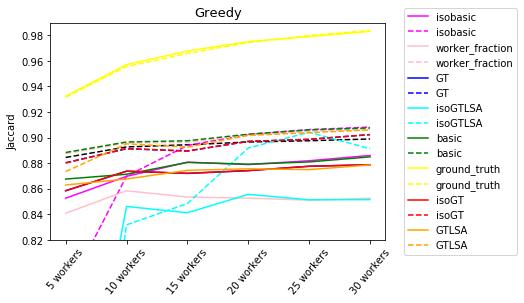

In [143]:
x,MV_noclust,MV_clust=clust_vs_noclust('MV',filtered=False)

# plt.plot(MV_noclust,label="MV",color="black")
plt.plot(MV_clust,color="black",linestyle="--")

for algo in greedyAlgoMap.keys():
    algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()["j"])
    algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()["j"])
    plt.plot(algo_noClust,label=algo,color=greedyAlgoMap[algo])
    plt.plot(algo_clust,color=greedyAlgoMap[algo],label=algo,linestyle='--')
    
    
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Greedy",fontsize=13)
plt.ylim(0.82,0.99)

In [144]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change due to clustering for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    print "{} :{}".format("MV",avrg_percent_change(MV_clust,MV_noclust))
    for algo in greedyAlgoMap.keys():
        algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,algo_noClust))

------------
percent change due to clustering for metric: precision
MV :0.369%
isobasic :-1.697%
worker_fraction :4.791%
GT :1.481%
isoGTLSA :-1.694%
basic :0.713%
ground_truth :-0.069%
isoGT :1.481%
GTLSA :1.389%
------------
percent change due to clustering for metric: recall
MV :1.672%
isobasic :1.820%
worker_fraction :0.484%
GT :0.919%
isoGTLSA :1.885%
basic :1.928%
ground_truth :0.011%
isoGT :0.919%
GTLSA :1.068%
------------
percent change due to clustering for metric: jaccard
MV :2.047%
isobasic :0.115%
worker_fraction :5.551%
GT :2.377%
isoGTLSA :-0.456%
basic :2.546%
ground_truth :-0.058%
isoGT :2.377%
GTLSA :2.645%
------------
percent change due to clustering for metric: FNR%
MV :-21.145%
isobasic :-23.536%
worker_fraction :-8.625%
GT :-19.735%
isoGTLSA :-25.826%
basic :-25.236%
ground_truth :-0.871%
isoGT :-19.735%
GTLSA :-15.351%
------------
percent change due to clustering for metric: FPR%
MV :-8.485%
isobasic :447.692%
worker_fraction :-79.602%
GT :-16.219%
isoGTLSA :47

In [145]:
m2m = {"precision":'p','recall':'r', 'jaccard':'j', u'FNR%':'fnr','FPR%':'fpr'}
for metric in ['precision', u'recall', u'jaccard', u'FNR%','FPR%']:
    print "------------"
    print "percent change compared to MV for metric:",metric
    x,MV_noclust,MV_clust=clust_vs_noclust('MV',metric=metric,filtered=False)
    for algo in greedyAlgoMap.keys():
        algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()[m2m[metric]])
        print "{} :{}".format(algo,avrg_percent_change(algo_clust,MV_clust))

------------
percent change compared to MV for metric: precision
isobasic :-2.307%
worker_fraction :-0.272%
GT :-2.121%
isoGTLSA :-9.741%
basic :0.282%
ground_truth :3.978%
isoGT :-2.121%
GTLSA :-0.105%
------------
percent change compared to MV for metric: recall
isobasic :0.196%
worker_fraction :0.900%
GT :2.219%
isoGTLSA :0.726%
basic :0.430%
ground_truth :4.167%
isoGT :2.219%
GTLSA :0.135%
------------
percent change compared to MV for metric: jaccard
isobasic :-1.999%
worker_fraction :0.524%
GT :-0.102%
isoGTLSA :-9.430%
basic :0.634%
ground_truth :7.938%
isoGT :-0.102%
GTLSA :0.148%
------------
percent change compared to MV for metric: FNR%
isobasic :-3.596%
worker_fraction :-14.767%
GT :-36.839%
isoGTLSA :-10.644%
basic :-7.102%
ground_truth :-69.898%
isoGT :-36.839%
GTLSA :-2.787%
------------
percent change compared to MV for metric: FPR%
isobasic :1539.615%
worker_fraction :14.667%
GT :44.273%
isoGTLSA :5769.529%
basic :3.505%
ground_truth :-65.190%
isoGT :44.273%
GTLSA :6.5

In [37]:
algo = "ground_truth"
algo_noClust = np.array(greedy_noclust[greedy_noclust["algo"]==algo].groupby(["num_workers"]).mean()["j"])
algo_clust = np.array(greedy_clust[greedy_clust["algo"]==algo].groupby(["num_workers"]).mean()["j"])

print "When using ground truth to estimate intersection areas, we can achieve a Jaccard of {:.3f}".format(algo_noClust[-1]) ," as an upper bound with 30 workers, which indicates that with better probablistic estimation of intersection area, aggregation-based methods can achieve close to perfect estimation, exceeding the results of any single `best' worker."

When using ground truth to estimate intersection areas, we can achieve a Jaccard of 0.983  as an upper bound with 30 workers, which indicates that with better probablistic estimation of intersection area, aggregation-based methods can achieve close to perfect estimation, exceeding the results of any single `best' worker.


In [321]:
np.array(NworkerPerformance["J [BestWorker]"])[-1]

0.91425952589506532

# Combined plot

__Comparison between Retreival and families of aggregation based methods__

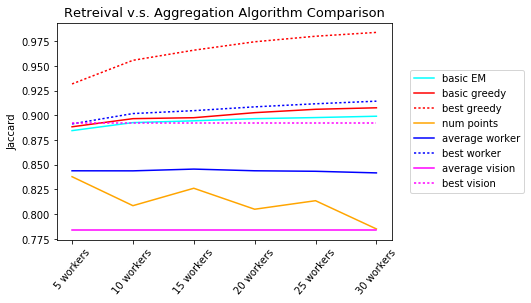

In [322]:
x,best_EM_noclust,best_EM_clust=clust_vs_noclust("basic",filtered=False)
plt.plot(best_EM_clust,color="cyan",label="basic EM")
best_greedy = np.array(greedy_clust[greedy_clust["algo"]=="basic"].groupby(["num_workers"]).mean()["j"])
plt.plot(best_greedy,color="red",label="basic greedy")
ground_truth_greedy = np.array(greedy_clust[greedy_clust["algo"]=="ground_truth"].groupby(["num_workers"]).mean()["j"])
plt.plot(ground_truth_greedy,linestyle=":",color="red",label="best greedy")
NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
# plt.plot(np.array(NworkerPerformance["J [AreaRatio]"]),color="orange",label="AreaRatio")
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),color="orange",label="num points")
plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),color="blue",label="average worker")
plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),linestyle=":",color="blue",label="best worker")
max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
average_vision = vision.mean()["j"]
y = np.ones_like(np.array(NworkerPerformance[algoJ]))
plt.plot(y*average_vision,label="average vision",color="magenta")
plt.plot(y*max_vision_k_thresh,linestyle=":",label="best vision",color="magenta")
lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
#plt.legend(loc="lower left",fontsize=8)    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Retreival v.s. Aggregation Algorithm Comparison",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.savefig("Retreival_vs_Aggregation.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

__Performance ratio of increase from 5 → 30 workers__

In [276]:
def worker_scaling_ratio(performance):
    return (performance[-1]-performance[0])/performance[0]*100

In [306]:
pchange=[]
for algo in  retreivalAlgoMap.keys():
    if algo!="AreaRatio":
        algoJ = "J [{}]".format(algo)
        performance = np.array(NworkerPerformance[algoJ])
        pchange.append([algo,worker_scaling_ratio(performance)])

In [307]:
pchange.append(["best greedy",worker_scaling_ratio(best_greedy)])
pchange.append(["best EM",worker_scaling_ratio(best_EM_clust)])
pchange.append(["ground truth greedy",worker_scaling_ratio(ground_truth_greedy)])
pchange.append(["MV",worker_scaling_ratio(algo_clust)])
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)

In [308]:
pchange=pd.DataFrame(np.array(pchange).T)

In [309]:
# pchange=pchange.transpose()

In [310]:
pchange.columns = pchange.iloc[0]
pchange.reindex(pchange.index.drop(0))

,AvrgWorker,NumPt,BestWorker,best greedy,best EM,ground truth greedy,MV
1,-0.251533707738,-6.30126685667,2.5795546392,2.16104579628,1.64422936203,5.59296181053,1.63397616318


In [316]:
# pchange.iloc[1]=round(pchange.iloc[1],2)

In [311]:
print tabulate(pchange,showindex=False,tablefmt="latex",floatfmt=".2f")

\begin{tabular}{lllllll}
\hline
 AvrgWorker      & NumPt          & BestWorker   & best greedy   & best EM       & ground truth greedy & MV            \\
 -0.251533707738 & -6.30126685667 & 2.5795546392 & 2.16104579628 & 1.64422936203 & 5.59296181053       & 1.63397616318 \\
\hline
\end{tabular}


__Effects of Clustering__

In [323]:
retreivalAlgoMap.keys()

['AvrgWorker', 'NumPt', 'BestWorker', 'AreaRatio']

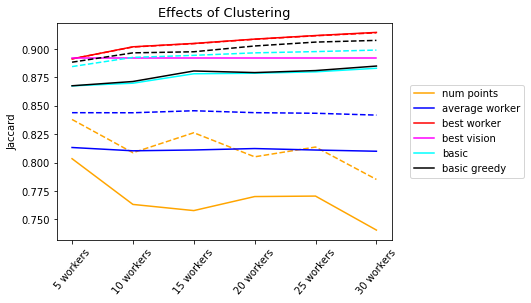

In [328]:
vision = pd.read_csv("pixel_em/vision_only_performance.csv")

NworkerPerformance = cluster_retreival_df.groupby("num_workers").mean()
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),linestyle='--',color="orange")#,label="num points [c]")
plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),linestyle='--',color="blue")#,label="average worker [c]")
plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),linestyle='--',color="red")#,label="best worker [c]")

NworkerPerformance = no_cluster_retreival_df.groupby("num_workers").mean()
plt.plot(np.array(NworkerPerformance["J [NumPt]"]),color="orange",label="num points")
plt.plot(np.array(NworkerPerformance["J [AvrgWorker]"]),color="blue",label="average worker")
plt.plot(np.array(NworkerPerformance["J [BestWorker]"]),color="red",label="best worker")

max_vision_k_thresh = vision.loc[vision.groupby(["objid"])['j'].idxmax()].mean()["j"]
y = np.ones_like(np.array(NworkerPerformance[algoJ]))
plt.plot(y*max_vision_k_thresh,label="best vision",color="magenta")

algo="basic"
x,algo_noclust,algo_clust=clust_vs_noclust(algo,filtered=False)
plt.plot(algo_noclust,label=algo,color = "cyan")
plt.plot(algo_clust,linestyle="--",color = "cyan")

best_greedy = np.array(greedy_clust[greedy_clust["algo"]=="basic"].groupby(["num_workers"]).mean()["j"])
plt.plot(best_greedy,color="black",linestyle="--")
best_noclust_greedy = np.array(greedy_noclust[greedy_noclust["algo"]=="basic"].groupby(["num_workers"]).mean()["j"])
plt.plot(best_noclust_greedy,color="black",label="basic greedy ")

lgd = plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
#plt.legend(loc="lower left",fontsize=8)    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Effects of Clustering",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.savefig("Effects_of_clustering.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Correlation of worker quality with individual worker performance

In [41]:
#qj_df=compute_worker_qualities_against_real_performance()#run once

In [46]:
from tqdm import tqdm

In [42]:
qj_df = pd.read_csv("EM_worker_qualities_against_real_performance.csv",index_col=0)
qj_df["num_workers"] = qj_df.apply(lambda x: int(x["sample"].split("workers")[0]),axis=1)

In [43]:
from scipy.stats import linregress
def corr_calc(selected_df):
    x = np.array(selected_df["qj"])
    y = np.array(selected_df["Jaccard [Self]"])
    linresult = linregress(x,y)
    return linresult.rvalue,linresult.pvalue

In [44]:
from sklearn import linear_model
def compute_multi_regression(selected_df,x_fields,yfields=["Precision [Self]","Recall [Self]","Jaccard [Self]"]):
    x = np.array(selected_df[x_fields])
    y = np.array(selected_df[yfields])
    # Initialize model
    regression_model = linear_model.LinearRegression()
    regression_model.fit(X = x, y = y)
    #print(regression_model.coef_)
    return regression_model.score(x,y)

GTLSA does poorly because qn1 not a very good estimator, if we look at the coefficients of qn1.

#### Linear regression with y=[P,R,J] , with clustering 

In [196]:
sample_lst = sample_specs.keys()

In [197]:
obj_clusters = clusters()
df_data = []
for sample_name in tqdm(sample_lst):
    for objid in object_lst:
        if str(objid) in obj_clusters[sample_name]:
            clusts = [obj_clusters[sample_name][str(objid)]]
        else:
            clusts = ["-1"]
        for cluster_id in clusts:
            worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
            if len(worker_ids) > 1 or cluster_id == "-1":
#                 if cluster_id!="" and cluster_id!="-1"  :
#                     outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
#                 else:
#                     outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
                selected_df = qj_df[(qj_df["sample"]==sample_name)&(qj_df["objid"]==objid)&(qj_df["clust"]==int(cluster_id))]
                if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                    #r,p = corr_calc(selected_df)
                    basic_R2 = compute_multi_regression(selected_df,["qj"])
                    GT_R2 = compute_multi_regression(selected_df,["qn","qp"])
                    GTLSA_R2 =compute_multi_regression(selected_df,["qn1","qp1","qn2","qp2"])
                    ibasic_R2 = compute_multi_regression(selected_df,["iqj"])
                    iGT_R2 = compute_multi_regression(selected_df,["iqn","iqp"])
                    iGTLSA_R2 =compute_multi_regression(selected_df,["iqn1","iqp1","iqn2","iqp2"])
                    df_data.append([sample_name,objid,cluster_id,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2])

In [199]:
qj_fit = pd.DataFrame(df_data,columns=["sample","objid","clust","basic_R2","GT_R2","GTLSA_R2","ibasic_R2","iGT_R2","iGTLSA_R2"])
qj_fit["num_workers"]=qj_fit["sample"].apply(lambda x: int(x.split("workers")[0]))
qj_fit_cluster_performance=qj_fit.groupby("num_workers",as_index=False).mean()[["num_workers",'basic_R2', u'GT_R2', u'GTLSA_R2','ibasic_R2', u'iGT_R2', u'iGTLSA_R2']]

In [200]:
qj_fit_cluster_performance

,num_workers,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2
0,5,0.575266,0.901452,0.896061,0.548344,0.901452,0.898049
1,10,0.568481,0.877450,0.883568,0.562938,0.877450,0.884157
2,15,0.547350,0.877485,0.877373,0.542371,0.877485,0.876928
3,20,0.589880,0.879940,0.884779,0.588206,0.879940,0.884320
4,25,0.584887,0.875037,0.882830,0.587338,0.875037,0.882210
5,30,0.598830,0.887627,0.895025,0.599246,0.887627,0.894137


In [201]:
qj_fit_cluster_performance.mean()

num_workers    17.500000
basic_R2        0.577449
GT_R2           0.883165
GTLSA_R2        0.886606
ibasic_R2       0.571407
iGT_R2          0.883165
iGTLSA_R2       0.886633
dtype: float64

correlation score is actually lower than in the clustering case, this means: 

       1) worker quality actually predicts p,r,j well in the no clustering case
       2) could also be because the actual N workers is smaller than the reported num_workers in sample, so don't fit as well

#### Linear regression with y=[P,R,J] , no clustering 

In [202]:
qj_df_no_clust = qj_df[qj_df["clust"]==-1]
df_data = []
for sample_name in tqdm(sample_lst):
    for objid in object_lst:
        cluster_ids = clust_df[(clust_df["objid"] == objid)].cluster.unique()
        for cluster_id in ["-1"] + list(cluster_ids):
            worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
            if len(worker_ids) > 1 or cluster_id == "-1":
#                 if cluster_id!="" and cluster_id!="-1"  :
#                     outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
#                 else:
#                     outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
                selected_df = qj_df_no_clust[(qj_df_no_clust["sample"]==sample_name)&(qj_df_no_clust["objid"]==objid)&(qj_df_no_clust["clust"]==int(cluster_id))]
                if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                    #r,p = corr_calc(selected_df)
                    basic_R2 = compute_multi_regression(selected_df,["qj"])
                    GT_R2 = compute_multi_regression(selected_df,["qn","qp"])
                    GTLSA_R2 =compute_multi_regression(selected_df,["qn1","qp1","qn2","qp2"])
                    ibasic_R2 = compute_multi_regression(selected_df,["iqj"])
                    iGT_R2 = compute_multi_regression(selected_df,["iqn","iqp"])
                    iGTLSA_R2 =compute_multi_regression(selected_df,["iqn1","iqp1","iqn2","iqp2"])
                    df_data.append([sample_name,objid,cluster_id,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2])

In [205]:
qj_fit = pd.DataFrame(df_data,columns=["sample","objid","clust","basic_R2","GT_R2","GTLSA_R2","ibasic_R2","iGT_R2","iGTLSA_R2"])
qj_fit["num_workers"]=qj_fit["sample"].apply(lambda x: int(x.split("workers")[0]))
qj_fit_no_cluster_performance = qj_fit.groupby("num_workers",as_index=False).mean()[["num_workers",'basic_R2', u'GT_R2', u'GTLSA_R2','ibasic_R2', u'iGT_R2', u'iGTLSA_R2']]

In [207]:
qj_fit_no_cluster_performance

,num_workers,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2
0,5,0.601423,0.906507,0.901074,0.576422,0.906507,0.904183
1,10,0.631618,0.894844,0.898587,0.633403,0.894844,0.898247
2,15,0.622339,0.897328,0.897985,0.622230,0.897328,0.896915
3,20,0.635873,0.894261,0.898608,0.637474,0.894261,0.897907
4,25,0.660482,0.900527,0.905311,0.661404,0.900527,0.904078
5,30,0.672567,0.906679,0.913740,0.675599,0.906679,0.912807


In [329]:
print tabulate(qj_fit_no_cluster_performance,showindex=False,headers=qj_fit_no_cluster_performance.columns,tablefmt="latex",floatfmt=".3g")

\begin{tabular}{rrrrrrr}
\hline
   num\_workers &   basic\_R2 &   GT\_R2 &   GTLSA\_R2 &   ibasic\_R2 &   iGT\_R2 &   iGTLSA\_R2 \\
\hline
             5 &      0.601 &   0.907 &      0.901 &       0.576 &    0.907 &       0.904 \\
            10 &      0.632 &   0.895 &      0.899 &       0.633 &    0.895 &       0.898 \\
            15 &      0.622 &   0.897 &      0.898 &       0.622 &    0.897 &       0.897 \\
            20 &      0.636 &   0.894 &      0.899 &       0.637 &    0.894 &       0.898 \\
            25 &      0.66  &   0.901 &      0.905 &       0.661 &    0.901 &       0.904 \\
            30 &      0.673 &   0.907 &      0.914 &       0.676 &    0.907 &       0.913 \\
\hline
\end{tabular}


#### Linear regression with y=[P,R,J] , overall 

In [56]:
df_data = []
for sample_name in tqdm(sample_lst):
    for objid in object_lst:
        cluster_ids = clust_df[(clust_df["objid"] == objid)].cluster.unique()
        for cluster_id in ["-1"] + list(cluster_ids):
            worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
            if len(worker_ids) > 1 or cluster_id == "-1":
#                 if cluster_id!="" and cluster_id!="-1"  :
#                     outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
#                 else:
#                     outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
                selected_df = qj_df[(qj_df["sample"]==sample_name)&(qj_df["objid"]==objid)&(qj_df["clust"]==int(cluster_id))]
                if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                    #r,p = corr_calc(selected_df)
                    basic_R2 = compute_multi_regression(selected_df,["qj"])
                    GT_R2 = compute_multi_regression(selected_df,["qn","qp"])
                    GTLSA_R2 =compute_multi_regression(selected_df,["qn1","qp1","qn2","qp2"])
                    ibasic_R2 = compute_multi_regression(selected_df,["iqj"])
                    iGT_R2 = compute_multi_regression(selected_df,["iqn","iqp"])
                    iGTLSA_R2 =compute_multi_regression(selected_df,["iqn1","iqp1","iqn2","iqp2"])
                    df_data.append([sample_name,objid,cluster_id,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2])

In [57]:
qj_fit = pd.DataFrame(df_data,columns=["sample","objid","clust","basic_R2","GT_R2","GTLSA_R2","ibasic_R2","iGT_R2","iGTLSA_R2"])
qj_fit["num_workers"]=qj_fit["sample"].apply(lambda x: int(x.split("workers")[0]))
qj_fit.groupby("num_workers",as_index=False).mean()[["num_workers",'basic_R2', u'GT_R2', u'GTLSA_R2','ibasic_R2', u'iGT_R2', u'iGTLSA_R2']]

,num_workers,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2
0,5,0.630526,0.919880,0.915480,0.606226,0.919880,0.919068
1,10,0.627047,0.900064,0.904288,0.621105,0.900064,0.904813
2,15,0.603264,0.896041,0.897668,0.598128,0.896041,0.897105
3,20,0.624533,0.896901,0.900600,0.627958,0.896901,0.901548
4,25,0.643451,0.899750,0.906443,0.641463,0.899750,0.907013
5,30,0.654717,0.912225,0.918863,0.662026,0.912225,0.918451


#### Linear regression with y=jaccard only

In [58]:
df_data = []
for sample_name in tqdm(sample_lst):
    for objid in object_lst:
        cluster_ids = clust_df[(clust_df["objid"] == objid)].cluster.unique()
        for cluster_id in ["-1"] + list(cluster_ids):
            worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
            if len(worker_ids) > 1 or cluster_id == "-1":
#                 if cluster_id!="" and cluster_id!="-1"  :
#                     outdir = '{}{}/obj{}/clust{}/'.format(PIXEL_EM_DIR, sample_name, objid,cluster_id)
#                 else:
#                     outdir = '{}{}/obj{}/'.format(PIXEL_EM_DIR, sample_name, objid)
                selected_df = qj_df[(qj_df["sample"]==sample_name)&(qj_df["objid"]==objid)&(qj_df["clust"]==int(cluster_id))]
                if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                    #r,p = corr_calc(selected_df)
                    basic_R2 = compute_multi_regression(selected_df,["qj"],["Jaccard [Self]"])
                    GT_R2 = compute_multi_regression(selected_df,["qn","qp"],["Jaccard [Self]"])
                    GTLSA_R2 =compute_multi_regression(selected_df,["qn1","qp1","qn2","qp2"],["Jaccard [Self]"])
                    ibasic_R2 = compute_multi_regression(selected_df,["iqj"],["Jaccard [Self]"])
                    iGT_R2 = compute_multi_regression(selected_df,["iqn","iqp"],["Jaccard [Self]"])
                    iGTLSA_R2 =compute_multi_regression(selected_df,["iqn1","iqp1","iqn2","iqp2"],["Jaccard [Self]"])
                    df_data.append([sample_name,objid,cluster_id,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2])

In [59]:
qj_fit = pd.DataFrame(df_data,columns=["sample","objid","clust","basic_R2","GT_R2","GTLSA_R2","ibasic_R2","iGT_R2","iGTLSA_R2"])
qj_fit["num_workers"]=qj_fit["sample"].apply(lambda x: int(x.split("workers")[0]))
qj_fit.groupby("num_workers",as_index=False).mean()[["num_workers",'basic_R2', u'GT_R2', u'GTLSA_R2','ibasic_R2', u'iGT_R2', u'iGTLSA_R2']]

,num_workers,basic_R2,GT_R2,GTLSA_R2,ibasic_R2,iGT_R2,iGTLSA_R2
0,5,0.660318,0.844492,0.837488,0.644129,0.844492,0.844324
1,10,0.682204,0.820955,0.828017,0.687377,0.820955,0.828748
2,15,0.683278,0.813650,0.814944,0.679045,0.813650,0.814229
3,20,0.704074,0.833764,0.837971,0.710381,0.833764,0.838822
4,25,0.733117,0.846328,0.852557,0.731658,0.846328,0.852507
5,30,0.742690,0.858385,0.866650,0.748829,0.858385,0.866185


In [60]:
# qj_fit[qj_fit["clust"]=='-1'].groupby("num_workers").mean()["R"]
# qj_fit[qj_fit["clust"]=='-1'].groupby("num_workers").mean()["p"]
# qj_fit[qj_fit["clust"]=='-1'].groupby("num_workers").mean()["p"]/len(qj_fit) #with Bonferonni correction
#-2*sum(np.log(qj_fit["p"])) #fisher's method normalization

In [61]:
# for objid in object_lst:
#     selected_df = qj_df[(qj_df["sample"]=="30workers_rand0")&(qj_df["objid"]==objid)&(qj_df["clust"]==-1)]
#     plt.figure()
#     plt.title(objid)
#     x = np.array(selected_df["qj"])
#     y = np.array(selected_df["Jaccard [Self]"])
#     linresult = linregress(x,y)
#     plt.plot(x,y,'o')
#     plt.plot(x,linresult.slope*x+linresult.intercept,'-')
#     plt.text(min(x),max(y),"R={:.2f}; p={:.2e}".format(linresult.rvalue,linresult.pvalue))
#     plt.xlabel("Worker quality qj")
#     plt.ylabel("Jaccard")
#     # plt.xlim(0.95,1)

# GT-estimation by picking best worker based on worker quality.

In [62]:
qj_df = pd.read_csv("EM_worker_qualities_against_real_performance.csv",index_col=0)
qj_df["num_workers"] = qj_df.apply(lambda x: int(x["sample"].split("workers")[0]),axis=1)

__Pick by Sorting__

In [63]:
best_basic_worker=qj_df.loc[qj_df.groupby(["sample","objid"])["qj"].idxmax()]
assert len(best_basic_worker)==31*46

In [64]:
best_basic_worker.groupby("num_workers").mean()["Jaccard [Self]"]

num_workers
5     0.791899
10    0.751593
15    0.756736
20    0.748013
25    0.722146
30    0.777821
Name: Jaccard [Self], dtype: float64

In [65]:
qj_df["GT_qjsum"] = qj_df.apply(lambda x: x["qp"]+x["qn"],axis=1)
best_GT_worker=qj_df.loc[qj_df.groupby(["sample","objid"])["GT_qjsum"].idxmax()]
assert len(best_GT_worker)==31*46
best_GT_worker.groupby("num_workers").mean()["Jaccard [Self]"]

num_workers
5     0.772541
10    0.726270
15    0.716735
20    0.708912
25    0.715807
30    0.750491
Name: Jaccard [Self], dtype: float64

In [66]:
qj_df["GTLSA_qjsum"] = qj_df.apply(lambda x: x["qp1"]+x["qn1"]+x["qn2"]+x["qp1"],axis=1)
best_GTLSA_worker=qj_df.loc[qj_df.groupby(["sample","objid"])["GTLSA_qjsum"].idxmax()]
assert len(best_GTLSA_worker)==31*46
best_GTLSA_worker.groupby("num_workers").mean()["Jaccard [Self]"]

num_workers
5     0.845210
10    0.825366
15    0.808331
20    0.796336
25    0.805057
30    0.803403
Name: Jaccard [Self], dtype: float64

__Pick by Linear Regression__

In [67]:
x_fields = ['qj']
y_fields = ['Precision [Self]', 'Recall [Self]', 'Jaccard [Self]']
df_data = []
for sample_name in tqdm(sample_lst):
    for objid in object_lst:
        selected_df =qj_df[qj_df["objid"]==objid]
        x = np.array(selected_df[x_fields])
        y = np.array(selected_df[y_fields])
        regression_model = linear_model.LinearRegression()
        regression_model.fit(X = x, y = y)
        
        cluster_ids = clust_df[(clust_df["objid"] == objid)].cluster.unique()
        for cluster_id in ["-1"] + list(cluster_ids):
            worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
            if len(worker_ids) > 1 or cluster_id == "-1":
                selected_df = qj_df[(qj_df["sample"]==sample_name)&(qj_df["objid"]==objid)&(qj_df["clust"]==int(cluster_id))]
                if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                    for row in selected_df.iterrows():
                        pred_p,pred_r,pred_j = regression_model.predict(row[1]["qj"])[0]
                        df_data.append([sample_name,objid,row[1]["qj"],cluster_id,pred_p,pred_r,pred_j])                        

In [68]:
qj_predicted = pd.DataFrame(df_data,columns=["sample","objid","qj","clust","p","r","j"])
qj_predicted["num_workers"]=qj_predicted["sample"].apply(lambda x: int(x.split("workers")[0]))

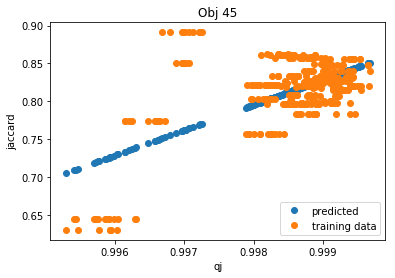

In [69]:
objid=45
selected_df =qj_predicted[qj_predicted["objid"]==objid]
selected_df_orig =qj_df[qj_df["objid"]==objid]
plt.plot(selected_df["qj"],selected_df["j"],'o',label="predicted")
plt.plot(selected_df_orig["qj"],selected_df_orig["Jaccard [Self]"],'o',label="training data")
plt.title("Obj {}".format(objid))
plt.xlabel("qj")
plt.ylabel("jaccard")
plt.legend()

In [70]:
best_qj_predicted = qj_predicted.loc[qj_predicted.groupby(["sample","objid"])["j"].idxmax()]
assert len(best_qj_predicted)==31*46
best_basic_predicted_score = best_qj_predicted.groupby("num_workers").mean()["j"]
best_basic_predicted_score

num_workers
5     0.848179
10    0.850849
15    0.851362
20    0.851667
25    0.852593
30    0.853102
Name: j, dtype: float64

In [71]:
import warnings
warnings.filterwarnings('ignore')

def predict_prj_linear_regression(qj_df, x_fields,y_fields = ['Precision [Self]', 'Recall [Self]', 'Jaccard [Self]']):
    df_data = []
    for sample_name in tqdm(sample_lst):
        for objid in object_lst:
            selected_df =qj_df[qj_df["objid"]==objid]
            x = np.array(selected_df[x_fields])
            y = np.array(selected_df[y_fields])
            regression_model = linear_model.LinearRegression()
            regression_model.fit(X = x, y = y)

            cluster_ids = clust_df[(clust_df["objid"] == objid)].cluster.unique()
            for cluster_id in ["-1"] + list(cluster_ids):
                worker_ids = np.array(clust_df[(clust_df["objid"] == objid) & (clust_df["cluster"] == int(cluster_id))].wid)
                if len(worker_ids) > 1 or cluster_id == "-1":
                    selected_df = qj_df[(qj_df["sample"]==sample_name)&(qj_df["objid"]==objid)&(qj_df["clust"]==int(cluster_id))]
                    if len(selected_df)>1: #only best clusters were ran, so ignore ones where no qj-df (non best clusters) was computed
                        for row in selected_df.iterrows():
                            pred_p,pred_r,pred_j = regression_model.predict(row[1][x_fields])[0]
                            df_data.append([sample_name,objid, cluster_id,pred_p,pred_r,pred_j])                        

    qj_predicted = pd.DataFrame(df_data,columns=["sample","objid","clust","p","r","j"])
    qj_predicted["num_workers"]=qj_predicted["sample"].apply(lambda x: int(x.split("workers")[0]))
    
    best_qj_predicted = qj_predicted.loc[qj_predicted.groupby(["sample","objid"])["j"].idxmax()]
    try:
        assert len(best_qj_predicted)==31*46
    except(AssertionError):
        print "assertion error:",len(best_qj_predicted)
    best_predicted_score = np.array(best_qj_predicted.groupby("num_workers").mean()["j"])
    return best_predicted_score,qj_predicted

In [72]:
qj_df_no_clust = qj_df[qj_df["clust"]==-1]

x_fields = ['qp1', 'qn1', 'qp2', 'qn2']
best_GTLSA_score,GTLSA_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

x_fields = ['iqp1', 'iqn1', 'iqp2', 'iqn2']
best_isoGTLSA_score,isoGTLSA_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

x_fields = ['qp', 'qn']
best_GT_score,GT_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

x_fields = ['iqp', 'iqn']
best_isoGT_score,isoGT_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

x_fields = ['iqj']
best_isobasic_score,isobasic_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

x_fields = ['qj']
best_basic_score,basic_predicted = predict_prj_linear_regression(qj_df_no_clust,x_fields)

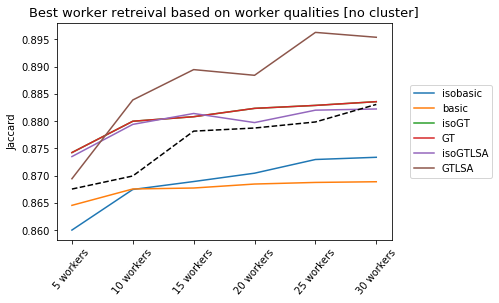

In [218]:
plt.plot(best_isobasic_score,label="isobasic")
plt.plot(best_basic_score,label="basic")
plt.plot(best_GT_score,label="isoGT")
plt.plot(best_isoGT_score,label="GT")
plt.plot(best_GTLSA_score,label="isoGTLSA")
plt.plot(best_isoGTLSA_score,label="GTLSA")
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(algo_noclust,linestyle="--",color = "black")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Best worker retreival based on worker qualities [no cluster]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

Best cluster

In [74]:
qj_df["sample_num"] = qj_df.apply(lambda x: int(x["sample"].split("rand")[-1]),axis=1)
# qj_df_clust = filter_best_clust(qj_df,best_clust_df)
# qj_df_clust.groupby(["sample","objid","clust"]).count()

In [75]:
def best_cluster(x):
    try:
        return obj_clusters[x["sample"]][str(x["objid"])]
    except(KeyError):
        return -1

qj_df["best_clust"]=qj_df.apply(lambda x: best_cluster(x),axis=1)
qj_df_clust = qj_df[qj_df["best_clust"]==qj_df["clust"]]

In [76]:
assert len(qj_df_clust.groupby(["sample","objid"],as_index=False).mean()[["sample","objid"]])==31*46

In [77]:
# len(isoGTLSA_predicted_clust[isoGTLSA_predicted_clust["objid"]==31])

In [78]:
x_fields = ['qp1', 'qn1', 'qp2', 'qn2']
best_GTLSA_score_clust,GTLSA_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

x_fields = ['iqp1', 'iqn1', 'iqp2', 'iqn2']
best_isoGTLSA_score_clust,isoGTLSA_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

x_fields = ['qp', 'qn']
best_GT_score_clust,GT_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

x_fields = ['iqp', 'iqn']
best_isoGT_score_clust,isoGT_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

x_fields = ['iqj']
best_isobasic_score_clust,isobasic_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

x_fields = ['qj']
best_basic_score_clust,basic_predicted_clust = predict_prj_linear_regression(qj_df_clust,x_fields)

  0%|          | 0/31 [00:00<?, ?it/s]         

assertion error: 1411


  0%|          | 0/31 [00:00<?, ?it/s]         

assertion error: 1411


  0%|          | 0/31 [00:00<?, ?it/s]         

assertion error: 1411


  0%|          | 0/31 [00:00<?, ?it/s]         

assertion error: 1411


  0%|          | 0/31 [00:00<?, ?it/s]         

assertion error: 1411


assertion error: 1411


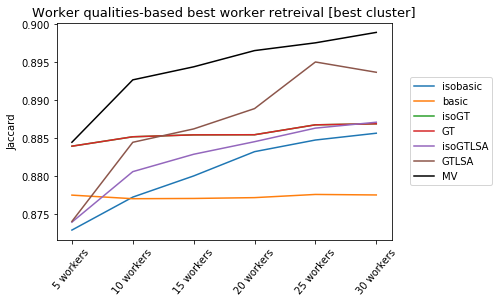

In [219]:
plt.plot(best_isobasic_score_clust,label="isobasic")
plt.plot(best_basic_score_clust,label="basic")
plt.plot(best_GT_score_clust,label="isoGT")
plt.plot(best_isoGT_score_clust,label="GT")
plt.plot(best_GTLSA_score_clust,label="isoGTLSA")
plt.plot(best_isoGTLSA_score_clust,label="GTLSA")
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(algo_clust,color = "black",label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Worker qualities-based best worker retreival [best cluster]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

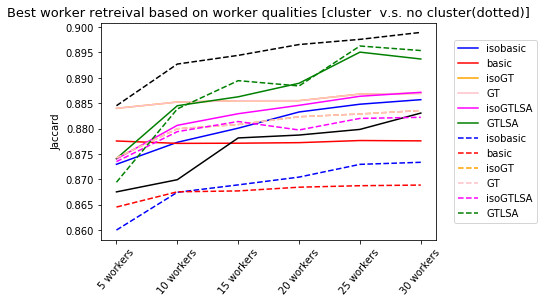

In [80]:
plt.plot(best_isobasic_score_clust,label="isobasic",color="blue")
plt.plot(best_basic_score_clust,label="basic",color="red")
plt.plot(best_GT_score_clust,label="isoGT",color="orange")
plt.plot(best_isoGT_score_clust,label="GT",color="pink")
plt.plot(best_GTLSA_score_clust,label="isoGTLSA",color="magenta")
plt.plot(best_isoGTLSA_score_clust,label="GTLSA",color="green")
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(algo_noclust,linestyle="-",color = "black")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Best worker retreival based on worker qualities [best cluster]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

plt.plot(best_isobasic_score,label="isobasic",linestyle="--",color="blue")
plt.plot(best_basic_score,label="basic",linestyle="--",color="red")
plt.plot(best_GT_score,label="isoGT",linestyle="--",color="orange")
plt.plot(best_isoGT_score,label="GT",linestyle="--",color="pink")
plt.plot(best_GTLSA_score,label="isoGTLSA",linestyle="--",color="magenta")
plt.plot(best_isoGTLSA_score,label="GTLSA",linestyle="--",color="green")
x,algo_noclust,algo_clust=clust_vs_noclust("MV",filtered=False)
plt.plot(algo_clust,linestyle="--",color = "black")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Best worker retreival based on worker qualities [cluster  v.s. no cluster(dotted)]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])

- show just the clustered case here